# State Estimation in the Budyko-Sellers energy balance model using algorithmic differentiation in JAX

This notebook runs the Budyko-Sellers 1-D energy balance model and uses its gradient to reduce the cost function J, which represents the mismatch between zonal mean temperature from NCEP and the model. 

References:

<font color='blue'>__[Notes on the Budyko-Sellers Model](https://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/Lectures/Lecture14%20--%20Diffusive%20energy%20balance%20model.html)__</font>

<font color='blue'>__[Notes on L-BFGS implementation](https://medium.com/gaussian-machine/implement-l-bfgs-optimization-from-scratch-3e5c909f9079)__</font>

Acknowledgements to Shreyas Gaikwad and Ian Fenty for providing the Fortran code which was adapted for this notebook.

In [ ]:
!pip install jax jaxlib

In [2]:
import jax.numpy as jnp
from jax import grad

import numpy as np
import jax.numpy as jnp
from jax import grad, lax,jit
import sys
N = 100
num_controls = 1
import netCDF4 as nc
import matplotlib.pyplot as plt
from collections import deque

## Step 0: download and plot the target data

We will use as our target the NCEP reanalysis surface temperature, averaged zonally and in time, to evolve our steady state temperature to.

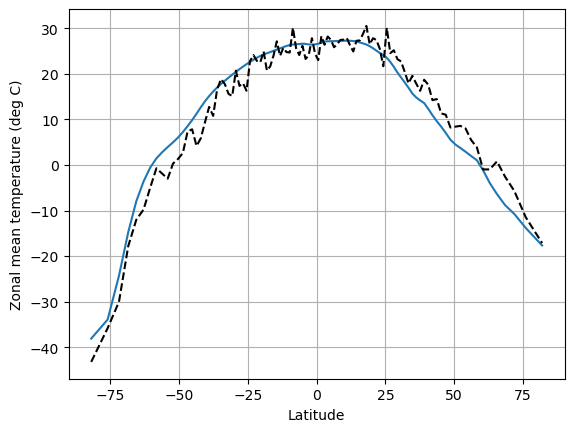

In [8]:
## Import NCEP temperature, get zonal mean and extrapolate to grid size

XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
LAT = jnp.arcsin(X) * 180.0 / jnp.pi
DX = X[1] - X[0]

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = nc.Dataset( ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc" )
lat_ncep = ncep_Ts.variables['lat']; lon_ncep = ncep_Ts.variables['lon']
Ts_ncep_annual = np.mean(ncep_Ts.variables['skt'][:], axis=(0,2) )
Ts_annual_interp = np.interp(LAT,np.array(lat_ncep[::-1]),Ts_ncep_annual[::-1])


# We will add a bit of noise and systematic error to this target and use it as a first "guess"

Ts_with_noise = Ts_annual_interp + np.random.randn(N)*2 + 5* X
plt.plot(LAT,jnp.array(Ts_annual_interp))
plt.plot(LAT,jnp.array(Ts_with_noise),'--k')
plt.xlabel('Latitude')
plt.ylabel('Zonal mean temperature (deg C)')
plt.grid()

## Step 1: Define the forward model

Budyko-Sellers is an energy balance model that evolves according to the equation:

$$ \frac{\partial E(\phi)}{\partial t} = ASR(\phi) - OLR(\phi) + \frac{D}{\cos \phi} \frac{\partial}{\partial \phi}\big(\cos\phi \frac{\partial T}{\partial \phi}\big) $$

Where $ ASR = (1-\alpha) Q $, $OLR = \epsilon \sigma T^4$, and D is a constant diffusivity, $\epsilon$ is emissivity, and $\sigma$ is the Stefan-Boltzmann constant. We will use a profile of solar radiation $Q$ that varies with latitude, and take the albedo $\alpha(\phi)$ as our control, i.e. the parameter to change in order to reduce the cost function. 

The cost function $J$ is defined as $\sqrt{\Sigma_i (T_i - T_{i,target})^2}/N$, or the norm of the difference between model and target temperature profiles.

The model is coded entirely using jax.numpy objects which will allow us to compute the gradient using jax.

In [29]:
def budyko_sellers_jax(XXS):
    MAX_ITER = 100000  # Reduce if needed for speed

    # Load target temperatures and convert to jax array
    TARGET_DT = jnp.array(Ts_annual_interp)
    # Constants
    S0 = 1366.0
    Q = S0 / 4.0
    SIGMA = 5.67e-8
    EPSILON = 0.63
    DIFF = 0.6
    
    # Set up grid by taking a constant dx, where x=sin(lat)

    XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
    X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
    LAT = jnp.arcsin(X) * 180.0 / jnp.pi
    DX = X[1] - X[0]

    # Insolation profile
    
    SX = Q * (1.0 - 0.482 * X**2) * 1.35 - 55.0

    # Initial temperature profile in Kelvins
    
    T_init = jnp.array(Ts_with_noise)+ 273
    
    
    # time step to satisfy CFL stability for diffusion
    
    DT = DX**2 / (2.0 * (DIFF)) * 0.5
    
    #First guess for albedo
    
    alpha0 = 0.354
    alpha2 = 0.25
    
    #Define iteration to loop through and evolve to steady state
    
    def step(_,state):
        T, XXS = state['T'], state['XXS']
        
        # First guess for albedo
        ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)
        
        # Add a perturbation to logit(albedo)
        ALPHA = jnp.log(ALPHA / (1.0 - ALPHA)) + XXS
        
        # Transform albedo back using a logistic function in order to constrain albedo from 0 to 1
        ALPHA = 1.0 / (1.0 + jnp.exp(-ALPHA))

        emiss_logit = jnp.log(EPSILON/(1.0-EPSILON)) 
        emiss = 1.0/(1.0+ jnp.exp(-emiss_logit))

        FIN = SX * (1.0 - ALPHA)
        FOUT = (emiss) * SIGMA * T**4

        DTDX_M = jnp.concatenate([jnp.array([0.0]), (T[1:] - T[:-1]) / DX])
        DTDX_P = jnp.concatenate([(T[1:] - T[:-1]) / DX, jnp.array([0.0])])

        FDIFF = (DIFF ) * ((1 - XEDGES[1:]**2) * DTDX_P -
                        (1 - XEDGES[:-1]**2) * DTDX_M) / DX

        T_new = T + DT * (FIN - FOUT + FDIFF)
        return {'T': T_new, 'XXS': XXS}
    
    
    
    init_state = {'T': T_init, 'XXS': XXS}
    
    # Use lax.fori_loop in order to evolve the state without letting the gradient calculation 
    # backpropagate through the loop
    
    state_final = lax.fori_loop(0, MAX_ITER, step, init_state)
    T_final,XXS = state_final['T'],state_final['XXS']
    
    # Recover albedo and emissivity from control adjustment
    
    alpha_raw =  alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)
    logits = jnp.log(alpha_raw / (1.0 - alpha_raw)) + XXS
    ALPHA = 1.0 / (1.0 + jnp.exp(-logits))
    emiss_logit = jnp.log(EPSILON/(1.0-EPSILON))
    emiss = 1.0/(1.0+ jnp.exp(-emiss_logit))
    # Cost: L2 norm between T_final and TARGET_DT (converted from K to C)
    J = jnp.sqrt(jnp.sum((T_final - TARGET_DT - 273.0)**2)) / N
    return J,T_final,ALPHA,emiss

def cost_fxn(XXS):
    J,_,_,_ = budyko_sellers_jax(XXS)
    return J

## Step 2: Calculate adjoint gradient

Since we made everything jax-compatible, this is one step!

In [30]:
from jax import grad

grad_J = grad(cost_fxn)

XXS = jnp.zeros(N*num_controls)
dJ_dXXS = grad_J(XXS) 

## Step 3a: minimize cost function using steepest descent

The steepest descent method is very simple to implement but does not converge quickly in most cases. We simply compute the gradient $\frac{dJ}{d\mathbf{XXS}}$, where $\mathbf{XXS}$ is our control parameter (albedo adjustment), and subtract $a \frac{dJ}{d\mathbf{XXS}}$ from our existing state $\mathbf{XXS}$ using some constant $a$.

In [31]:
## gradient descent
XXS = jnp.zeros(N*num_controls)
a = 1
max_iter = 300
J = 1000
i = 0
Js_sd = np.zeros(max_iter)
while((J > 0) & (i < max_iter)):
    J,T,alpha,emiss = budyko_sellers_jax(XXS)
    g = grad_J(XXS)
    print(f'Cost function at step {i}: {J}')
    XXS = XXS - a*g
    Js_sd[i] = J
    i = i+1
T_sd = T
D_sd = 0.6 + XXS[:N]
alpha_sd = alpha
eps_sd = emiss

Cost function at step 0: 0.9019944667816162
Cost function at step 1: 0.8654133677482605
Cost function at step 2: 0.8307064771652222
Cost function at step 3: 0.7978968024253845
Cost function at step 4: 0.766935408115387
Cost function at step 5: 0.7377644181251526
Cost function at step 6: 0.7104021310806274
Cost function at step 7: 0.6847699880599976
Cost function at step 8: 0.6609514355659485
Cost function at step 9: 0.6387990117073059
Cost function at step 10: 0.6182181239128113
Cost function at step 11: 0.5992925763130188
Cost function at step 12: 0.581866443157196
Cost function at step 13: 0.5658392906188965
Cost function at step 14: 0.5512291193008423
Cost function at step 15: 0.5378579497337341
Cost function at step 16: 0.5257656574249268
Cost function at step 17: 0.5147967338562012
Cost function at step 18: 0.5048035979270935
Cost function at step 19: 0.4958052337169647
Cost function at step 20: 0.4876251220703125
Cost function at step 21: 0.4802452027797699
Cost function at step 

Cost function at step 180: 0.31971144676208496
Cost function at step 181: 0.3194400370121002
Cost function at step 182: 0.3191651999950409
Cost function at step 183: 0.3188989758491516
Cost function at step 184: 0.3186335563659668
Cost function at step 185: 0.31837475299835205
Cost function at step 186: 0.3181103765964508
Cost function at step 187: 0.3178514242172241
Cost function at step 188: 0.3175848722457886
Cost function at step 189: 0.3173274099826813
Cost function at step 190: 0.31707295775413513
Cost function at step 191: 0.31682276725769043
Cost function at step 192: 0.316565603017807
Cost function at step 193: 0.3163158893585205
Cost function at step 194: 0.31606432795524597
Cost function at step 195: 0.3158169090747833
Cost function at step 196: 0.3155685365200043
Cost function at step 197: 0.3153286278247833
Cost function at step 198: 0.3150818943977356
Cost function at step 199: 0.3148449659347534
Cost function at step 200: 0.3146054446697235
Cost function at step 201: 0.3

## Step 3b: Minimize cost function using BFGS algorithm

To converge faster to a minimum, we implement the BFGS algorithm instead of steepest descent. BFGS is a quasi-Newton method that descends according the stepping equation $\mathbf{XXS}_{i+1} = \mathbf{XXS}_i - a(\mathcal H_n)^{-1} \frac{dJ_n}{d\mathbf{XXS_n}}$, where $\mathcal H$ is the Hessian of the cost function with respect to the controls. 

The BFGS algorithm approximates the inverse of the hessian, $B_n = (\mathcal H_n)^{-1}$, by taking into account the inverse Hessian at the previous state, beginning with $B_0$ which we take to be the identity. It converges quickly but requires storing $B$ in memory at each step, which requires $N^2$ memory. For our simple model, $N = O(100)$ and this is not a problem, but $B$ quickly exceeds available memory as the problem scales.

In order to make the descent as efficient as possible, we implement a backtracking line search function to get the optimal value of $a$. We adjust $a$ until we acheive a sufficient decrease in the cost function $J$.

For additional information on the implementation of BFGS, see the resource included at the top of this notebook.

In [ ]:
def backtracking_line_search(x, J, g, d, a0=1.0, c=1e-4, tau=0.1, max_iter=20):
    """
    x   : current point
    J   : current cost at x
    g   : current gradient at x
    d   : search direction
    fxn : function that returns cost given x
    a0  : initial step size
    c   : Armijo parameter
    tau : step size reduction factor
    """
    a = a0
    for _ in range(max_iter):
        x_new = x + a * d
        J_new = cost_fxn(x_new)

        # Armijo (sufficient decrease) condition
        if J_new <= J + c * a * jnp.dot(g, d):
            return a  # condition satisfied
        a *= tau  # reduce step size

    return None  # break the loop if no sufficient decrease can be found

In [42]:
# BFGS Algorithm
XXS = jnp.zeros(N*num_controls)
a = 1e-4
max_i = 30
i = 0
B = jnp.identity(N*num_controls)
J_bfgs = []

J_prev,T_prev,alpha,emiss = budyko_sellers_jax(XXS)
g_prev = grad_J(XXS)
XXS_prev = XXS
print(f'Cost function at step 1: {J_prev}')

XXS = XXS - a*g_prev


for i in range(max_i):
    
    J,T,alpha,emiss = budyko_sellers_jax(XXS)
    print(f'Cost function at step {i+2}: {J}')
    g = grad_J(XXS)

    y = g - g_prev
    s = XXS - XXS_prev
    rho = 1/(jnp.dot(y.T,s) + 1e-4)
    

    B = B.dot(np.identity(N*num_controls)-rho * jnp.outer(s,y)) + \
        rho *jnp.outer(s,s.T)

    B = (np.identity(N*num_controls) - rho * jnp.outer(y,s).T) @ (B)

    

    J_bfgs.append(J)
    g_prev = g
    XXS_prev = XXS
    T_prev = T
    alpha_prev = alpha
    emiss_prev = emiss
    d = B.dot(g)
    a = backtracking_line_search(XXS,J,g,d,a0=1)
    if (a is None) or (np.allclose(g,np.zeros(N*num_controls),rtol=1e-5)) \
        or (J_prev - J < 1e-7):
        print(f'Line search failed? {a is None}')
        print(f'Zero gradient reached? {np.allclose(g,np.zeros(N*num_controls),rtol=1e-5)}')
        print(f'J decreasing too slow? {J_prev - J < 1e-7}')
        print('BFGS optimization complete')
        break
    XXS = XXS - d
    J_prev = J
    print(f'a={a}')


T_bfgs = T
D_bfgs = 0.6 + XXS[:N]
alpha_bfgs = alpha
eps_bfgs = emiss


Cost function at step 1: 0.9019944667816162
Cost function at step 2: 0.9019919633865356
a=1.0000000000000004e-05
Cost function at step 3: 0.8654109835624695
a=1.0000000000000004e-05
Cost function at step 4: 0.7522355914115906
a=0.00010000000000000003
Cost function at step 5: 0.7434554100036621
a=1.0000000000000005e-07
Cost function at step 6: 0.5419070720672607
a=0.00010000000000000003
Cost function at step 7: 0.5409877896308899
a=1.0000000000000004e-05
Cost function at step 8: 0.5322856307029724
a=1.0000000000000004e-06
Cost function at step 9: 0.4269392490386963
a=0.00010000000000000003
Cost function at step 10: 0.4262291193008423
a=0.00010000000000000003
Cost function at step 11: 0.42473235726356506
a=1.0000000000000004e-05
Cost function at step 12: 0.4218163788318634
a=1.0000000000000004e-06
Cost function at step 13: 0.3919733464717865
a=1.0000000000000004e-06
Cost function at step 14: 0.3896982967853546
a=1.0000000000000004e-05
Cost function at step 15: 0.3875754475593567
a=1.0000

## Step 3c: Gradient descent using L-BFGS

As an alternative to BFGS with drastically lower memory requirements, we implement Limited Memory BFGS (L-BFGS). Instead of saving the full inverse Hessian $B$, we work only with the last $k$ states and gradients, each of which is size $N$. The parameter $k$ can adjusted to balance By expanding out $B$ as a sum of vector outer products and computing the matrix-vector product $B\mathbf{g}$, where $\mathbf{g} = \frac{dJ_n}{d\mathbf{XXS_n}}$, the cost function gradient, from right to left, so we are only ever taking vector products and not storing a full matrix.

In [43]:
# Limited memory BFGS (L-BFGS): use only last k derivatives
k = 10
s_list = deque(maxlen=k)
y_list = deque(maxlen=k)
rho_list = deque(maxlen=k)
XXS = jnp.zeros(N*num_controls)
max_i = 30
g = grad_J(XXS)
a = 1e-5
J_lbfgs = []
for i in range(max_i):
    
    J, T, alpha, emiss = budyko_sellers_jax(XXS)
    print(f'Cost at step {i+1}: {J:.6f}')
    
    q = g
    alpha_list = []

    # First loop: compute intermediate q
    for s, y, rho in reversed(list(zip(s_list, y_list, rho_list))):
        alpha_i = rho * jnp.dot(s, q)
        alpha_list.append(alpha_i)
        q = q - alpha_i * y

    # Scaling of initial Hessian approximation (identity)
    if len(s_list) > 110:
        gamma = jnp.dot(s_list[-1], y_list[-1]) / jnp.dot(y_list[-1], y_list[-1])
    else:
        gamma = 1.0
    r = gamma * q

    # Second loop: compute direction
    for (s, y, rho, alpha_i) in zip(s_list, y_list, rho_list, reversed(alpha_list)):
        beta = rho * jnp.dot(y, r)
        r = r + s * (alpha_i - beta)

    # Descent direction
    d = -r

    # Step
    a = backtracking_line_search(XXS,J,g,d,a0=1.1)
    if i >1 and ((a is None) or (np.allclose(g,np.zeros(N*num_controls)))): 
        print('L-BFGS optimization complete')
        break
    XXS_new = XXS + a * d

    g_new = grad_J(XXS_new)
    
    # Update s, y, rho
    s = XXS_new - XXS
    y = g_new - g
    rho = 1.0 / (jnp.dot(y, s) + 1e-6)  

    if (J==J) and jnp.dot(y, s) > 1e-10:  # Check curvature condition
         s_list.append(s)
         y_list.append(y)
         rho_list.append(rho)
    else:
         break
    # Update variables
    XXS = XXS_new
    g = g_new
    J_lbfgs.append(J)

T_lbfgs = T
D_lbfgs = 0.6 + XXS[:N]
alpha_lbfgs = alpha
eps_lbfgs = emiss


Cost at step 1: 0.901994
Cost at step 2: 0.861791
Cost at step 3: 0.764575
Cost at step 4: 0.479973
Cost at step 5: 0.456631
Cost at step 6: 0.443736
Cost at step 7: 0.439493
Cost at step 8: 0.434973
Cost at step 9: 0.404793
Cost at step 10: 0.378452
Cost at step 11: 0.353856
Cost at step 12: 0.346814
Cost at step 13: 0.345275
Cost at step 14: 0.338867
Cost at step 15: 0.331406
Cost at step 16: 0.322322
Cost at step 17: 0.318736
Cost at step 18: 0.316856
Cost at step 19: 0.312634
Cost at step 20: 0.303424
Cost at step 21: 0.287763
Cost at step 22: 0.279714
Cost at step 23: 0.277045
Cost at step 24: 0.276193
Cost at step 25: 0.276018
Cost at step 26: 0.275487
Cost at step 27: 0.274194
Cost at step 28: 0.272196
Cost at step 29: 0.270088
Cost at step 30: 0.269049


Text(0, 0.5, 'T')

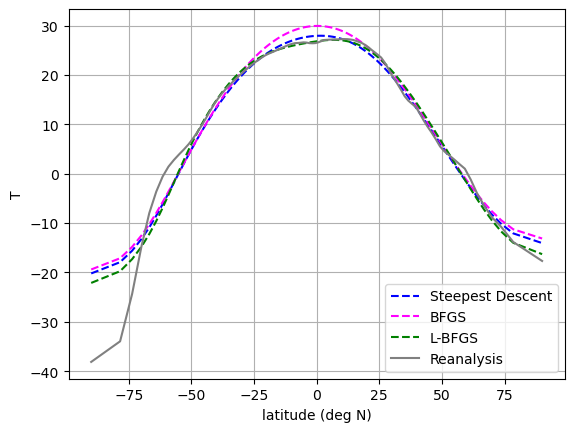

In [47]:
# Plot the calculated temperature profiles 


lat = np.arcsin(np.linspace(-1.0, 1.0, N)) * 180.0 / jnp.pi
T_ncep = Ts_annual_interp
plt.plot(lat, T_sd-273,c='blue',ls='--',label='Steepest Descent')
plt.plot(lat, T_bfgs-273,c='magenta',ls='--',label='BFGS')
plt.plot(lat, T_lbfgs-273,c='g',ls='--',label='L-BFGS')
plt.plot(lat,T_ncep,'-',c='gray',label='Reanalysis')
plt.legend()
plt.grid()
plt.xlabel('latitude (deg N)')
plt.ylabel('T')

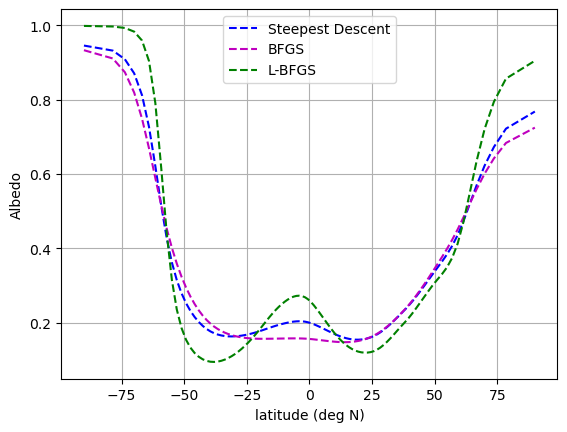

In [48]:
# Plot final adjustments to albedo from each algorithm

plt.plot(lat,alpha_sd,'--b',label='Steepest Descent')
plt.plot(lat,alpha_bfgs,'--m',label='BFGS')
plt.plot(lat,alpha_lbfgs,'--g',label='L-BFGS')
plt.xlabel('latitude (deg N)')
plt.grid()
plt.ylabel('Albedo')
plt.legend()

Text(0, 0.5, 'Cost function (J)')

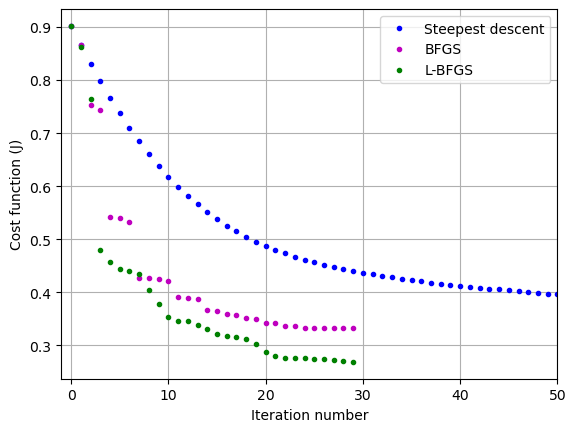

In [46]:
# Show Cost function decrease with iteration for each algorithm

plt.plot(Js_sd,'.b',label='Steepest descent')
plt.plot(J_bfgs,'.m',label='BFGS')
plt.plot(J_lbfgs,'.g',label='L-BFGS')
plt.legend()
plt.xlim(-1,50)
plt.grid()
plt.xlabel('Iteration number')
plt.ylabel('Cost function (J)')